In [1]:
from math import pi, sin, cos

from siltsong.stars import blackbody
from siltsong.dust import mrn, thermal_emission, henyey_greenstein
from siltsong import cartesian_to_spherical, plot_density, plot_density_powernorm, plot_density_lognorm, radiative_transfer

In [2]:
view_length = 1e16
distance_steps = 200
theta_steps = 360
phi_steps = 360
distance_substeps = 10
dr = view_length / 2 / distance_steps
ds = dr / distance_substeps
dphi = pi / phi_steps

resolution = 201
depth = 201
depth_substeps = 10
dw = view_length / depth
ds_depth = dw / depth_substeps
grid_size = view_length / resolution

inclination_degrees = 60
inclination = pi * (inclination_degrees / 180)
sin_inc = sin(inclination)
cos_inc = cos(inclination)

ms_count = 1e5

wavelength = 5.47e-5

grain_size_min = 5e-7
grain_size_max = 1e-4
exponent = -3.5
rho_gr = 3
sigma_rho_gr = 1.109

In [3]:
central_source = blackbody(wavelength, temperature = 20000)
    
sca_cm_squared_per_g, ext_cm_squared_per_g = mrn(grain_size_min, grain_size_max, exponent, rho_gr, sigma_rho_gr, wavelength)

sca_cm_squared_per_g, ext_cm_squared_per_g = mrn() # Alternatively use default parameters, identical to above

source_function = thermal_emission(wavelength, temperature = 10)

def scattering_phase_function(angle):
    return henyey_greenstein(angle, asymmetry_constant = 0.6)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/siltsong/dust.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scattering_efficiency_integral = quad(lambda a: a ** (2 + exponent) * Q_sca_lambda(2 * pi * a / wavelength), grain_size_min, grain_size_max)[0] # integral after P in formual A8 of Li et al. 2024
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/siltsong/dust.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to 

In [4]:
def density_spherical(r, theta):
    if r <= 2e14 or r > 4e15:
        return 0
    return 10 / r ** 2

def density_cartesian(x, y, z):
    r, theta, _ = cartesian_to_spherical(x, y, z)
    return density_spherical(r, theta)

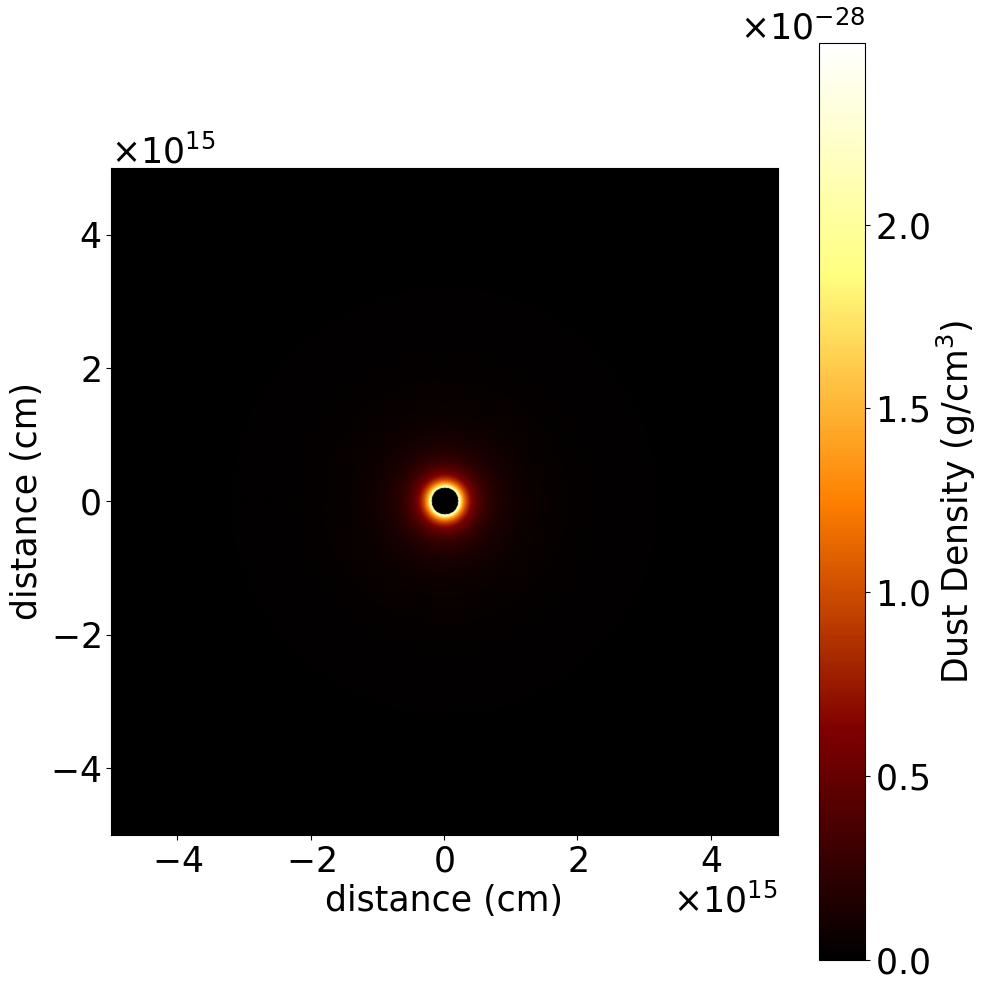

In [7]:
plot_density(density_cartesian, view_length)

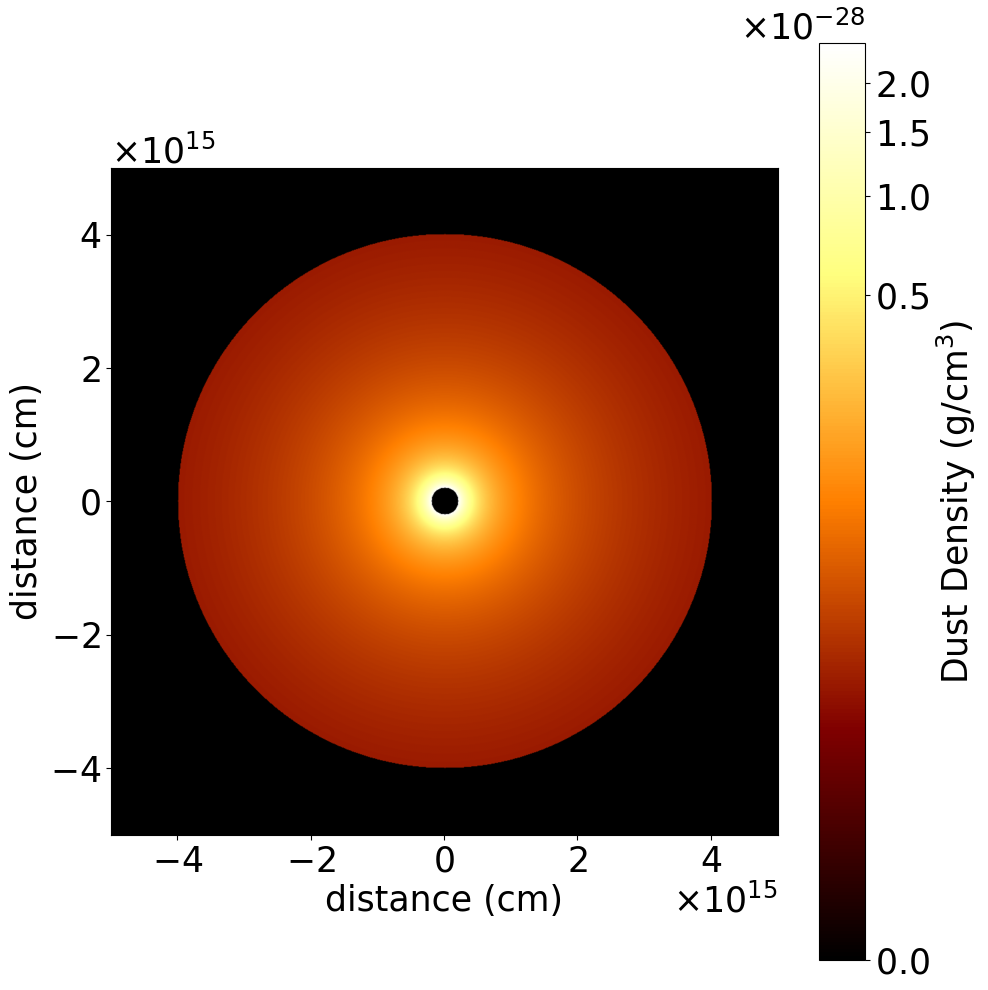

In [8]:
plot_density_powernorm(density_cartesian, view_length, power = 0.2)

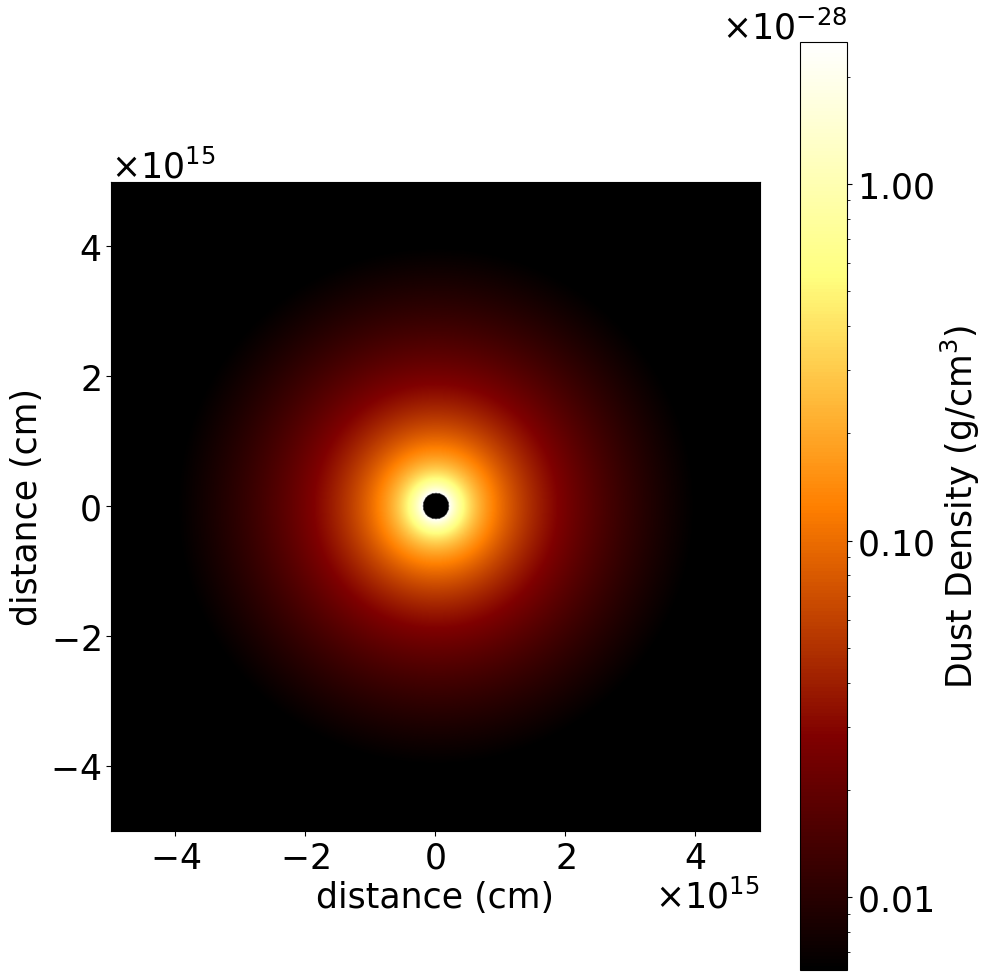

In [9]:
plot_density_lognorm(density_cartesian, view_length)

In [ ]:
def radiative_transfer_general(view_length, inclination_degrees, resolution, 
                       central_source, 
                       density_spherical, density_cartesian, 
                       sca_cm_squared_per_g, ext_cm_squared_per_g, source_function, scattering_phase_function, 
                       depth, depth_substeps, distance_steps, distance_substeps, theta_steps, phi_steps, ms_count):

    if isinstance(density_spherical, Callable):
        density_spherical_list = [density_spherical]
    elif isinstance(density_spherical, list) and all(isinstance(d, Callable) for d in density_spherical):
        density_spherical_list = density_spherical
    else:
        raise TypeError("density_spherical must be a callable or a list of callables")

    if isinstance(density_cartesian, Callable):
        density_cartesian_list = [density_cartesian]
    elif isinstance(density_cartesian, list) and all(isinstance(d, Callable) for d in density_cartesian):
        density_cartesian_list = density_cartesian
    else:
        raise TypeError("density_cartesian must be a callable or a list of callables")

    if isinstance(sca_cm_squared_per_g, (int, float)):
        sca_list = [sca_cm_squared_per_g]
    elif isinstance(sca_cm_squared_per_g, list) and all(isinstance(s, (int, float)) for s in sca_cm_squared_per_g):
        sca_list = sca_cm_squared_per_g
    else:
        raise TypeError("sca_cm_squared_per_g must be a number or a list of numbers")

    if isinstance(ext_cm_squared_per_g, (int, float)):
        ext_list = [ext_cm_squared_per_g]
    elif isinstance(ext_cm_squared_per_g, list) and all(isinstance(s, (int, float)) for s in ext_cm_squared_per_g):
        ext_list = ext_cm_squared_per_g
    else:
        raise TypeError("ext_cm_squared_per_g must be a number or a list of numbers")

    if isinstance(source_function, (int, float)):
        source_function_list = [source_function]
    elif isinstance(source_function, list) and all(isinstance(s, (int, float)) for s in source_function):
        source_function_list = source_function
    else:
        raise TypeError("source_function must be a number or a list of numbers")

    if isinstance(scattering_phase_function, Callable):
        scattering_phase_function_list = [scattering_phase_function]
    elif isinstance(scattering_phase_function, list) and all(isinstance(d, Callable) for d in scattering_phase_function):
        scattering_phase_function_list = scattering_phase_function
    else:
        raise TypeError("scattering_phase_function must be a callable or a list of callables")

    list_lengths = [len(density_spherical_list), len(density_cartesian_list), len(sca_list), len(ext_list), len(source_function_list), len(scattering_phase_function_list),]

    if len(set(list_lengths)) != 1:
        raise ValueError(
            f"All parameter lists must have the same length, but got lengths: "
            f"density_spherical={len(density_spherical_list)}, "
            f"density_cartesian={len(density_cartesian_list)}, "
            f"sca_cm_squared_per_g={len(sca_list)}, "
            f"ext_cm_squared_per_g={len(ext_list)}, "
            f"source_function={len(source_function_list)}, "
            f"scattering_phase_function={len(scattering_phase_function_list)}."
        )

    phi_steps = phi_steps * 2
    theta_steps = theta_steps * 2
    
    dr = view_length / 2 / distance_steps
    ds = dr / distance_substeps
    dphi = 2 * pi / phi_steps
    
    dw = view_length / depth
    ds_depth = dw / depth_substeps
    grid_size = view_length / resolution
    
    inclination = pi * (inclination_degrees / 180)
    sin_inc = sin(inclination)
    cos_inc = cos(inclination)

    def cartesian_to_observer(x, y, z):
        u = x * cos_inc - z * sin_inc
        v = y
        w = x * sin_inc + z * cos_inc
        return u, v, w
    
    def observer_to_cartesian(u, v, w):
        x = u * cos_inc + w * sin_inc
        y = v
        z = -u * sin_inc + w * cos_inc
        return x, y, z
    
    def observer_to_pixels(u, v, w):
        px = int(floor((u + grid_size / 2) / grid_size) + ((resolution - 1) / 2))
        py = int(floor((v + grid_size / 2) / grid_size) + ((resolution - 1) / 2))
        d = int((view_length / 2 - w) / dw)
        return px, py, d
    
    def pixels_to_observer(px, py, d):
        u = (px - ((resolution - 1) / 2)) * grid_size
        v = (py - ((resolution - 1) / 2)) * grid_size
        w = view_length / 2 - d * dw
        return u, v, w

    def propagate_center_to_first(I, r, theta, phi):
        
        for i in range(distance_substeps):

            I_cur = I

            for ext_cm_squared_per_g, density_spherical, source_function in zip(ext_list, density_spherical_list, source_function_list):
    
                k_v = ext_cm_squared_per_g * density_spherical(r + i * ds, theta, phi) # attenuation coefficient, units: cm^-1
                j_v = source_function * k_v

                dI = -I_cur * k_v * ds + j_v * ds
                I = I + dI
    
        return I

    def compute_one_angle(i, j):
        row = np.ones(distance_steps + 1) * central_source
        theta = (i + 1) * pi / theta_steps  # You can change this to acos(1 - (i + 1)/theta_steps) for isotropic sampling
        phi = j * dphi + dphi / 2
    
        for k in range(1, distance_steps + 1):
            r = k * dr
            row[k] = propagate_center_to_first(row[k - 1], r, theta, phi)
    
        return row * sin(theta)
    
    def compute_spherical():
        results = Parallel(n_jobs = -1)(
            delayed(compute_one_angle)(i, j)
            for i in range(theta_steps)
            for j in range(phi_steps)
        )
        return np.array(results).reshape(theta_steps, phi_steps, distance_steps + 1)
    
    spherical_array = compute_spherical()
    cubical_array = np.zeros((resolution, resolution, depth))
    image_array = np.zeros((resolution, resolution, depth))
    
    def send_photon(i, j, k):
    
        r = j * dr
        theta = (i + 1) * pi / theta_steps
        phi = k * dphi + dphi / 2
    
        intensity = spherical_array[i, k, j]
    
        x, y, z = spherical_to_cartesian(r, theta, phi)
        u, v, w = cartesian_to_observer(x, y, z)
        px, py, d = observer_to_pixels(u, v, w)
    
        scattering_angle = vector_angle(u, v, w, 0, 0, 1)
    
        if px >= 0 and px < resolution and py >= 0 and py < (resolution + 1) // 2:

            for sca_cm_squared_per_g, density_spherical, scattering_phase_function in zip(sca_list, density_spherical_list, scattering_phase_function_list):
                
                increment = intensity * (1 - exp(-dr * sca_cm_squared_per_g * density_spherical(r, theta, phi))) # now that the photon arrived, calculate the chance to scatter between r + dr
                cubical_array[px, py, d] += increment # reserved for further scattering
                image_array[px, py, d] += increment * scattering_phase_function(scattering_angle) # peel-off amount

    print("Sending photons from the central source(s): ")
    
    for i in tqdm(range(theta_steps)):
        for j in range(1, distance_steps + 1):
            for k in range(phi_steps):
                send_photon(i, j, k)
    
    image_array *= (pi / theta_steps) * dphi
    cubical_array *= (pi / theta_steps) * dphi
    image_array[(resolution - 1) // 2, (resolution - 1) // 2, (depth - 1) // 2] += central_source

    def propagate_any(I, x0, y0, z0, random_x, random_y, random_z, random_steps):

        x, y, z = x0, y0, z0
        
        for i in range(random_steps):

            I_cur = I

            x += random_x * ds_depth
            y += random_y * ds_depth
            z += random_z * ds_depth
    
            if x ** 2 + y ** 2 + z ** 2 >= view_length ** 2:
                return 0, 0, 0, 0 # photon escapes

            for ext_cm_squared_per_g, density_cartesian, source_funcion in zip(ext_list, density_cartesian_list, source_function_list):
        
                k_v = ext_cm_squared_per_g * density_cartesian(x, y, z) # attenuation coefficient, units: cm^-1
                j_v = source_function * k_v
        
                dI = -I_cur * k_v * ds_depth + j_v * ds_depth
                I = I + dI
        
        return x, y, z, I
    
    def multiple_scattering(weight, px, py, d):
    
        u, v, w = pixels_to_observer(px, py, d)
        x0, y0, z0 = observer_to_cartesian(u, v, w)
        
        while True:
    
            random_phi = 2 * pi * np.random.rand()
            random_z = 2 * np.random.rand() - 1
            random_r = sqrt(1 - random_z ** 2)
            random_x = random_r * cos(random_phi)
            random_y = random_r * sin(random_phi)
    
            random_steps = int(np.random.randint(depth * depth_substeps) + 1)
    
            I = cubical_array[px, py, d]
            scattering_angle = vector_angle(x0, y0, z0, random_x, random_y, random_z)

            if len(scattering_phase_function_list) == 1:
                
                I = I * scattering_phase_function(scattering_angle)

            else: # compute a weighted average of the scattering phase functions

                total_sca_cm_squared = 0
                averaged_scattering_phase_function = 0

                for sca_cm_squared_per_g, density_cartesian, scattering_phase_function in zip(sca_list, density_cartesian_list, scattering_phase_function_list):

                    sca_cm_squared_cur = density_cartesian(x0, y0, z0) * sca_cm_squared_per_g
                    total_sca_cm_squared += sca_cm_squared_cur
                    averaged_scattering_phase_function += sca_cm_squared_cur * scattering_phase_function(scattering_angle)

                if total_sca_cm_squared > 0:
                    averaged_scattering_phase_function /= total_sca_cm_squared
                else:
                    averaged_scattering_phase_function = 0

                averaged_scattering_phase_function = averaged_scattering_phase_function / total_sca_cm_squared
                
                I = I * averaged_scattering_phase_function
    
            x_dest, y_dest, z_dest, I_dest = propagate_any(I, x0, y0, z0, random_x, random_y, random_z, random_steps)
    
            if I_dest == 0:
                break
    
            u_dest, v_dest, w_dest = cartesian_to_observer(x_dest, y_dest, z_dest)
            px_dest, py_dest, d_dest = observer_to_pixels(u_dest, v_dest, w_dest)
    
            if px_dest >= 0 and px_dest < resolution and py_dest >= 0 and py_dest < resolution and d_dest >= 0 and d_dest < depth:
    
                peel_off_angle = vector_angle(random_x, random_y, random_z, 0, 0, 1)

                for sca_cm_squared_per_g, density_cartesian, scattering_phase_function in zip(sca_list, density_cartesian_list, scattering_phase_function_list):
                    
                    image_array[px_dest, py_dest, d_dest] += weight * I_dest * (1 - exp(-ds_depth * sca_cm_squared_per_g * density_cartesian(x_dest, y_dest, z_dest))) * scattering_phase_function(peel_off_angle)
            
            else:
                break

    all_positions = [
        (px, py, d)
        for px in range(resolution)
        for py in range(resolution)
        for d in range(depth)
    ]
    
    ms_weight = resolution * resolution * depth / ms_count

    weight = ms_weight * 2 * pi * view_length / ds_depth
    
    sampled_positions = random.sample(all_positions, int(ms_count))

    print("Tracing multiple scattered photons: ")
    
    for px, py, d in tqdm(sampled_positions):
        multiple_scattering(ms_weight, px, py, d)

    def propagate_los(I, px, py, d):

        u, v, w = pixels_to_observer(px, py, d)
        
        for i in range(depth_substeps):

            I_cur = I
            
            x, y, z = observer_to_cartesian(u, v, w - i * ds_depth)

            for ext_cm_squared_per_g, density_cartesian, source_funcion in zip(ext_list, density_cartesian_list, source_function_list):
        
                k_v = ext_cm_squared_per_g * density_cartesian(x, y, z) # attenuation coefficient, units: cm^-1
                j_v = source_function * k_v
    
                dI = -I_cur * k_v * ds_depth + j_v * ds_depth
                I = I + dI
        
        return I

    print("Performing peel-off: ")
    
    for px in tqdm(range(resolution)):
        for py in range(resolution):
            for d in reversed(range(depth - 1)):
                image_array[px, py, d] += propagate_los(image_array[px, py, d + 1], px, py, d)

    return image

In [ ]:
image = radiative_transfer(view_length, inclination_degrees, resolution, 
                           central_source, 
                           density_spherical, density_cartesian, 
                           sca_cm_squared_per_g, ext_cm_squared_per_g, source_function, scattering_phase_function, 
                           depth, depth_substeps, distance_steps, distance_substeps, theta_steps, phi_steps, 
                           ms_count)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

buffer = np.min(image[image > 0])
buffered_image = image.copy()
buffered_image[buffered_image <= buffer] = buffer

plt.imshow(buffered_image, origin = 'lower', cmap = 'afmhot', norm = LogNorm())
plt.colorbar()
plt.show()

In [ ]:
# END